# **Transfer Learning Workshop 2**

## Transfer Learning Across Tasks: From Classification To Semantic Segmentation

------------

Welcome to day 2 of ComputeFest 2020! In this workshop, we will explore and play around with the common applications of transfer learning. Transfer learning can be used to improve performance on small datasets, across tasks, and even to recognize and properly process unseen examples.

The flow of the workshop is as follows:
1. The basics of transfer learning
2. **Transfer Learning from classification to segmentation**
3. Transfer learning through distillation

## **Transfer Learning Across Tasks**

- Transfer learning is not only useful for simple classification task (e.g. Workshop 1).
- Pre-trained classification models can even transfer knowledge to other tasks like semantic segmentation. 

## **Goal**

- Understand the task of semantic segmentation
- Get familiar with some segmentation networks
- Build your own segmentation network
- Improve your segmentation network by transfering knowledge from classification networks

## **Structure**

1. Introduction to Semantic Segmentation.

   1.1 What is semantic segmentation?

   1.2 Examples
   
   1.3 Two common proposed networks: FCN and U-Net

2. Let’s dive into the code

   2.1 Setup

   2.2 Input pipeline

   2.3 The segmentation network architecture

   2.4 Training the network from scratch 

   2.5 Visualize results

3. Transfer Learning to the rescue: again?
   
   3.1 Re-run training with pretrained encoder weights

   3.2 Quantitative results

   3.3 Qualitative results

   3.4 Running on webcam images

   3.5 Running on external images

------------

# **1. Introduction to Semantic Segmentation.**

## **1.1 What is semantic segmentation?**
  - *Classification:* assigning a single label to *the entire picture.* 
  - *Semantic segmentation:* assigning a semantically meaningful label to *every pixel in the image.*

<img src="https://miro.medium.com/max/2645/1*nXlx7s4wQhVgVId8qkkMMA.png" alt="https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf" width=80%/>


## **1.2 Examples**

- Autonomous vehicles
- Biomedical Imaging
- Aerial Surveying
- Geo Sensing, etc.

   <img src="https://miro.medium.com/max/1200/1*dJRA7-IjccrkCWw86V-oUg.gif
" alt="https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf" width=80%/>


## **1.3 Two common network architectures**

Note that current state-of-the-art segmentation architectures tend to differ (sometimes quite significantly) from the architectures presented below, but for brevity and simplicity, we restrict it to these two.

- **FCN: Fully-Convolutional Networks.** [(Paper)](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf)
  - *How can we transform a Classification Network to Segmentation Network?*
  
     Changing the fully connected layers into convolution layers enables a classification net to output a heatmap. 
 
     <img src="https://i.imgur.com/WQM9Ksf.png" alt="https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf" width=80%/>
 - Adding layers and a spatial loss (between the output and the segmentation mask) produces an efficient framework for end-to-end dense prediction learning.
 - The FCN can be seen as an encoder and decoder network:
   - Encoder: Spatially downsample the input image to a smaller size (while gaining more channels) through a series of convolutions
   - Decoder: The encoded output is then upsampled either through bilinear interpolation or a series of transposed convolutions to yield a high-resolution dense prediction. 

      <img src="https://i.imgur.com/VG3N19J.png" alt="https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf" width=80%/>

-  **U-Net: a symetric FCN architecture with skip connections.** [(Paper)](https://arxiv.org/pdf/1505.04597.pdf)
  - U-Net consists of an almost symetric encoder and decoder. 
  - Most importantly it has skip connections from the output of convolution blocks to the corresponding input of the transposed-convolution block at the same level: these skip connections allow gradients to flow more effectively and provides information from multiple scales of the image.
  
    <img src="https://www.researchgate.net/profile/James_Brown124/publication/328781846/figure/fig1/AS:690171381051392@1541561088555/Diagram-of-the-U-net-architecture-and-two-phase-training-scheme-for-optic-localization.ppm" alt="https://towardsdatascience.com/knowledge-distillation-simplified-dd4973dbc764" width=80%/>

   
   


# **2. Let’s dive into the code:**


## **2.1 Setup**

In this section, we set up the working directory and color palettes for visualization.

Note that retrieving the dataset can take a few minutes.

In [0]:
!git clone https://github.com/VincentCa/transfer_learning.git

import os
os.chdir("transfer_learning")
!ls

fatal: destination path 'transfer_learning' already exists and is not an empty directory.
deeplab_model.py  ImageSets   model_pretrained.h5  __pycache__
helpers.py	  JPEGImages  model_scratch.h5	   SegmentationClassSubset


TensorFlow 2.x selected.

Classes to detect, with corresponding colors:


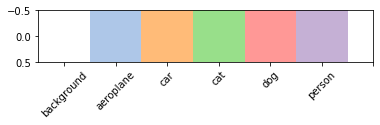

In [0]:
%load_ext autoreload
%autoreload 2
%tensorflow_version 2.x

import time
import helpers
from helpers import *
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np

start = time.time()

cmap_ref = cm.get_cmap('tab20', 12)
cmap_seg = np.zeros((6, 4))
cmap_seg[0] = [0.7, 0.7, 0.7, 0]
for i in range(1, 6):
  cmap_seg[i] = cmap_ref(i)

cmap_seg = ListedColormap(cmap_seg)
print("\nClasses to detect, with corresponding colors:")
plt.imshow([[0, 1, 2, 3, 4, 5]], cmap=cmap_seg)
plt.xticks([0,1 ,2 ,3 ,4 ,5, 6], LABEL_NAMES[[0, 1, 7, 8, 12, 15]], rotation=45)

INPUT_SPATIAL = 224

In [0]:
source_raw = 'JPEGImages'
source_mask = 'SegmentationClassSubset'

with open('ImageSets/Segmentation/train.txt', 'r') as fp:
    files_train = [line.rstrip() for line in fp.readlines()]

with open('ImageSets/Segmentation/val.txt', 'r') as fp:
    files_val = [line.rstrip() for line in fp.readlines()]

# Filter down to the subset we are using.
files_train = [f for f in files_train if os.path.isfile(os.path.join('SegmentationClassSubset/' + f + '.npy'))]
files_val = [f for f in files_val if os.path.isfile(os.path.join('SegmentationClassSubset/' + f + '.npy'))]

# Split train-validation into 80:20 instead of the original split.
files_all = np.array(sorted(list(set(files_train).union(set(files_val)))))
index = int(len(files_all) * 0.8)
files_train = files_all[:index]
files_val = files_all[index:]
print(len(files_train), 'training', len(files_val), 'validation')
labels = ['background', 'aeroplane', 'car', 'cat', 'dog', 'person']

792 training 199 validation


## **2.2 Input pipeline**

In this section, we define two generators to provide data to the network: one for training and one for validation data.

We then define the network architecture: we are using a Keras pre-defined version of MobileNet-v2 as encoder, and build a very simple and light-weight matching decoder on top. We also add skip-connections, similar to U-NET. We end up with an encoder-decoder architecture of matching input/output resolution.

Finally, we define a slightly modified cross-entropy loss that takes border/unlabeled pixels into account through masking.

In [0]:
gen_train = CustomDataGenerator(source_raw=source_raw,
                                source_mask=source_mask,
                                filenames=files_train.copy(),
                                batch_size=4,
                                target_height=INPUT_SPATIAL,
                                target_width=INPUT_SPATIAL)

gen_val = CustomDataGenerator(source_raw=source_raw,
                              source_mask=source_mask,
                              filenames=files_val.copy(),
                              batch_size=4,
                              target_height=INPUT_SPATIAL,
                              target_width=INPUT_SPATIAL)

Here, we visualize an example pair produced by the generator. The generator marks border/unlabeled pixels as -1, background as 0 and specific classes as 1 and over.

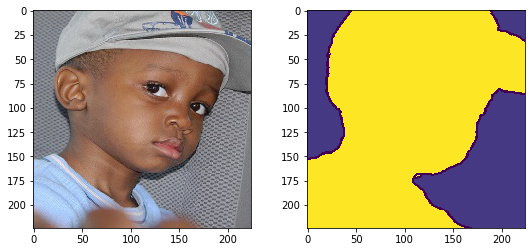

X shape (224, 224, 3) min-mean-max -0.9607843160629272 0.056160148258913356 1.0
Y shape (224, 224, 1) min-mean-max -1 3.4568917410714284 5


In [0]:
X, Y = gen_train[0]
X = X[0]
Y = Y[0]

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.imshow(norm_vis(X, mode='rgb'))
plt.subplot(1, 2, 2)
plt.imshow(Y[:, :, 0])
plt.show()

print('X shape', X.shape, 'min-mean-max', X.min(), X.mean(), X.max())
print('Y shape', Y.shape, 'min-mean-max', Y.min(), Y.mean(), Y.max())

## **2.3 The segmentation network architecture**

In [0]:
K.clear_session()

def get_fcn(pretrained=True, add_activation=True, verbose=False, n_outputs=1):
    def conv_block_simple(prev, num_filters, name):
        return Conv2D(num_filters, activation='relu', kernel_size=(3, 3), padding='same', name=name + '_3x3')(prev)

    
    selected_encoder = tf.keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=(INPUT_SPATIAL, INPUT_SPATIAL, 3), 
        include_top=False, 
        alpha=1.0,
        weights='imagenet' if pretrained else None)
    
    for l in selected_encoder.layers:
        l.trainable = False
        if verbose:
            print(l.name, l.output.shape)
            
    conv0 = selected_encoder.get_layer("expanded_conv_project").output # 112 x 112
    conv1 = selected_encoder.get_layer("block_2_project").output # 56 x 56
    conv2 = selected_encoder.get_layer("block_5_project").output # 28 x 28
    conv3 = selected_encoder.get_layer("block_12_project").output # 14 x 14
   
    up6 = selected_encoder.output 
    conv7 = up6

    up8 = concatenate([UpSampling2D()(conv7), conv3], axis=-1)
    conv8 = conv_block_simple(up8, 128, "conv8_1")

    up9 = concatenate([UpSampling2D()(conv8), conv2], axis=-1)
    conv9 = conv_block_simple(up9, 64, "conv9_1")

    up10 = concatenate([UpSampling2D()(conv9), conv1], axis=-1)
    conv10 = conv_block_simple(up10, 32, "conv10_1")

    up11 = concatenate([UpSampling2D()(conv10), conv0], axis=-1)
    conv11 = conv_block_simple(up11, 32, "conv11_1")

    up12 = UpSampling2D()(conv11)
    conv12 = conv_block_simple(up12, 32, "conv12_1")

    x = Conv2D(N_CLASSES, (1, 1), activation=None, name="prediction")(conv12)
    
    if add_activation:
      x = tf.keras.layers.Activation("softmax")(x)

    model = tf.keras.Model(selected_encoder.input, [x] * n_outputs)
    if verbose:
        model.summary()
    return model

In [0]:
def masked_loss(y_true, y_pred):
    """Defines a masked loss that ignores border/unlabeled pixels (represented as -1).
    
    Args:
      y_true: Ground truth tensor of shape [B, H, W, 1].
      y_pred: Prediction tensor of shape [B, H, W, N_CLASSES].
    """
    gt_validity_mask = tf.cast(tf.greater_equal(y_true[:, :, :, 0], 0), dtype=tf.float32) # [B, H, W]
    
    # The sparse categorical crossentropy loss expects labels >= 0. 
    # We just transform -1 into any valid class label, it will then be masked anyways.
    y_true = K.abs(y_true)
    raw_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)  # [B, H, W].

    masked = gt_validity_mask * raw_loss
    return tf.reduce_mean(masked)


## **2.4 Training the network from scratch**

Given the very small dataset, it is hard to train a large architecture such as MobileNet-v2 and accompanying decoder robustly. As we see below, training from scratch leads to very strong overfitting, and is not successful.

In [0]:
number_of_epochs = 10

model_scratch = get_fcn(pretrained=False, verbose=False)
model_scratch.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=masked_loss)

print('total number of model parameters:', model_scratch.count_params())

total number of model parameters: 3984166


We now run training. Depending on the GPU assigned, this should take about 4 minutes.

In [0]:
history_scratch = model_scratch.fit(gen_train, epochs=number_of_epochs, verbose=1, validation_data=gen_val)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 198 steps, validate for 49 steps
Epoch 1/10
198/198 [==============================] - 12s 59ms/step - loss: 1.1362 - val_loss: 1.5970
Epoch 2/10
198/198 [==============================] - 6s 30ms/step - loss: 1.0535 - val_loss: 1.5923
Epoch 3/10
198/198 [==============================] - 6s 30ms/step - loss: 1.0334 - val_loss: 1.5894
Epoch 4/10
198/198 [==============================] - 6s 31ms/step - loss: 1.0200 - val_loss: 1.5916
Epoch 5/10
198/198 [==============================] - 6s 31ms/step - loss: 1.0085 - val_loss: 1.5874
Epoch 6/10
198/198 [==============================] - 6s 31ms/step - loss: 1.0046 - val_loss: 1.5877
Epoch 7/10
198/198 [==============================] - 6s 31ms/step - loss: 0.9922 - val_loss: 1.5839
Epoch 8/10
198/198 [==============================] - 6s 31ms/step - loss: 0.9862 - val_loss: 1.5807
Epoch 9/10
198/198 [==============================] - 6s 31ms/step - loss: 0.9811 - val_loss: 1.58

If you encounter any problems with above training cell, you can uncomment the cell below to load weights that we pre-trained using the same code.

In [0]:
# Uncomment to restore pre-trained weights instead:
# model_scratch = load_model('model_scratch.h5', custom_objects={'masked_loss': masked_loss})

## **2.5 Visualize results**

In [0]:
def show_examples(model, deeplab=False):
  for i in [2, 13, 10, 9]:
    img = cv2.imread(os.path.join(source_raw, files_val[i] + '.jpg')).astype(np.float32) / 255.
    img = np.flip(img, axis=2)
    img = cv2.resize(img, (256, 256), cv2.INTER_LINEAR)
    gt = np.load(os.path.join(source_mask, files_val[i] + '.npy'))

    ret = run_predict(model, np.expand_dims(img, axis=0), deeplab=deeplab)[0]
    if ret.shape[-1] == 21:
      print("Reducing pedicted classes to the classes to keep.")
      ret = ret[:,:,:,CLASSES_TO_KEEP]
    ret_amax = np.argmax(ret, axis=2)

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.title('input')
    plt.imshow(norm_vis(img, mode='rgb'))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('GT')
    plt.imshow(norm_vis(img, mode='rgb'))
    plt.imshow(gt[:, :, 0], cmap=cmap_seg, vmin=0, vmax=N_CLASSES, alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(norm_vis(img, mode='rgb'))
    plt.imshow(ret_amax, cmap=cmap_seg, vmin=0, vmax=N_CLASSES, alpha=0.5)
    plt.axis('off')

    plt.figure(figsize=(14, 4))
    for i, label in enumerate(labels[1:]):
        plt.subplot(1, 5, i+1)
        plt.title(label + ': ' + str(round(ret[:, :, i+1].mean(), 2)))
        plt.imshow(ret[:, :, i+1], vmin=0.0, vmax=1.0)
        plt.axis('off')

    plt.show()

Here, we show results of our network trained from scratch. As we can see, we don't obtain any meaningful result. Our architecture is quite highly parameterized, and we expect it to learn a difficult segmentation task from just a few examples - this is too difficult without prior knowledge.

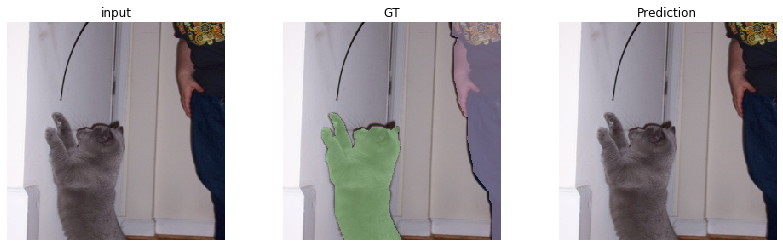

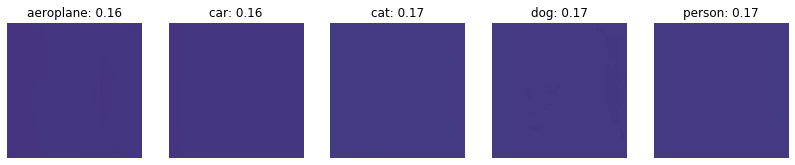

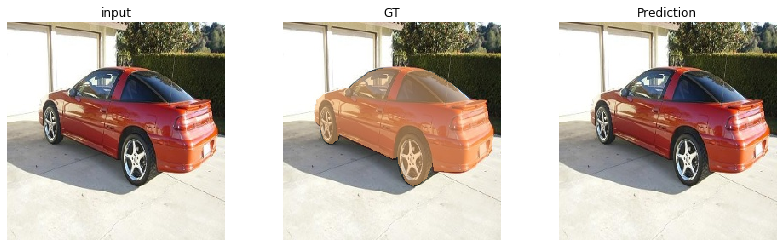

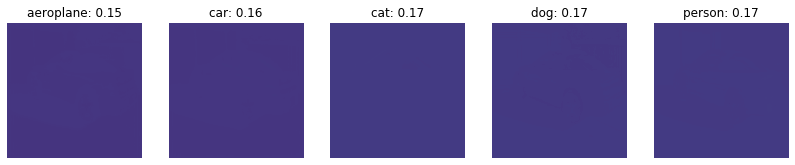

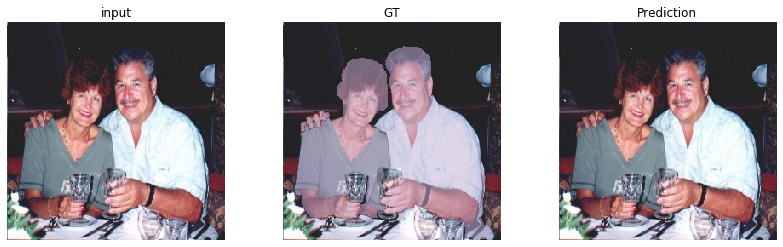

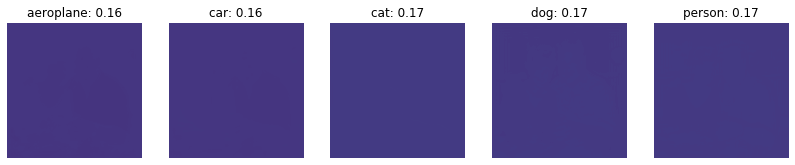

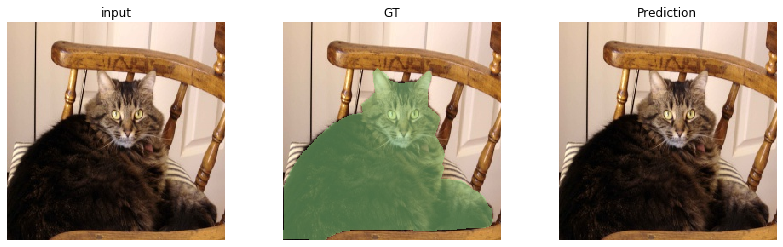

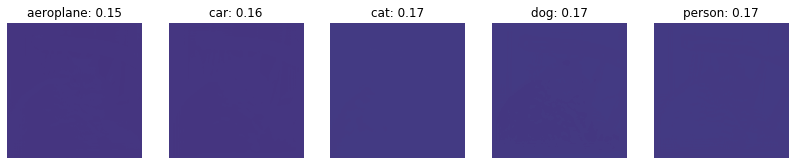

In [0]:
show_examples(model_scratch)


# **3. Transfer Learning to the rescue: again?**

Keras makes it easy to use pre-trained weights. Here, we use the same architecture, but initialize the MobileNet-based encoder with weights from ImageNet classification pre-training. The initial loss is much lower, and we see how it converges much faster and to a much lower loss value both in training and validation.

While this is still a very minimal example and far from state-of-the-art segmentation methods, we see that even with very small datasets, we can successfully train a basic model by transferring knowledge from other tasks.

## **3.1 Re-run training with pretrained encoder weights**

In [0]:
model_pretrained = get_fcn(pretrained= True, #
                           verbose=False)

model_pretrained.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),  # Feel free to play around with the learning rate
                         loss=masked_loss)

print('total number of model parameters:', model_pretrained.count_params())

total number of model parameters: 3984166


We now run training. Depending on the GPU assigned, this should take about 4 minutes.

In [0]:
history_pretrained = model_pretrained.fit(gen_train, epochs=number_of_epochs, verbose=1, validation_data=gen_val)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 198 steps, validate for 49 steps
Epoch 1/10
198/198 [==============================] - 9s 46ms/step - loss: 0.8382 - val_loss: 0.6510
Epoch 2/10
198/198 [==============================] - 6s 31ms/step - loss: 0.6044 - val_loss: 0.5402
Epoch 3/10
198/198 [==============================] - 6s 31ms/step - loss: 0.5344 - val_loss: 0.5165
Epoch 4/10
198/198 [==============================] - 6s 31ms/step - loss: 0.4940 - val_loss: 0.4776
Epoch 5/10
198/198 [==============================] - 6s 32ms/step - loss: 0.4511 - val_loss: 0.4837
Epoch 6/10
198/198 [==============================] - 6s 32ms/step - loss: 0.4231 - val_loss: 0.5191
Epoch 7/10
198/198 [==============================] - 6s 33ms/step - loss: 0.3886 - val_loss: 0.4875
Epoch 8/10
198/198 [==============================] - 6s 33ms/step - loss: 0.3658 - val_loss: 0.4181
Epoch 9/10
198/198 [==============================] - 6s 33ms/step - loss: 0.3374 - val_loss: 0.468

If you encounter any problems with above training cell, you can uncomment the cell below to load weights that we pre-trained using the same code.

In [0]:
# Uncomment to restore pre-trained weights instead:
# model_pretrained = load_model('model_pretrained.h5', custom_objects={'masked_loss': masked_loss})

## **3.2 Quantitative results**

In this section, we show a quantitative comparison between the two models. We plot training and validation accuracy over the different training epochs. There are major differences between training from scratch and intializing from pre-trained weights.

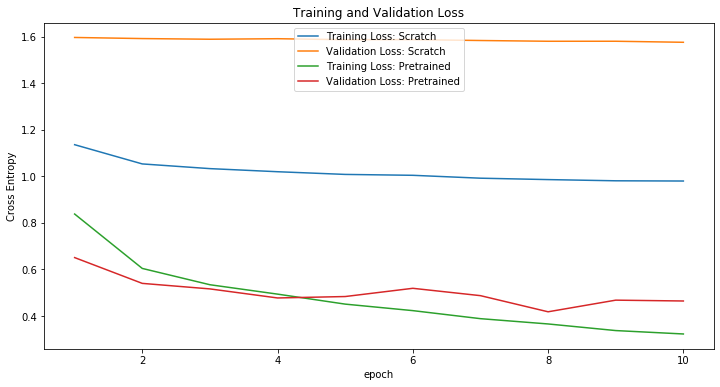

In [0]:
plot_history([history_scratch, history_pretrained], ['Scratch', 'Pretrained'])

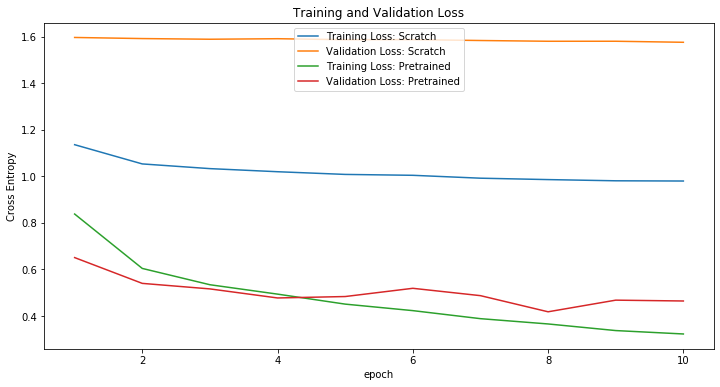

In [0]:
plot_history([history_scratch, history_pretrained], ['Scratch', 'Pretrained'])

We also show how the networks compare in terms of weighted IoU. For simplicity, we evaluate this on a few individual examples. For more representative metrics, this can be computed over the entire set.

In [0]:
def jaccard_distance(y_true, y_pred):
    """Jaccard distance for semantic segmentation.

    Also known as the intersection-over-union loss.
    Jaccard = (|X & Y|) / (|X| + |Y| - |X & Y|)
            = sum(|A * B|) / (sum(|A|)+sum(|B|) - sum(|A * B|))

    Args:
        y_true: Ground truth segmentation mask.
        y_pred: Predicted segmentation mask.
    """
    intersection = np.sum(np.abs(y_true * y_pred))
    sum_ = np.sum(np.abs(y_true) + np.abs(y_pred))
    if (sum_ - intersection) == 0:
      jac = 0
    else: 
      jac = (intersection ) / (sum_ - intersection)
    return jac

models = [model_scratch, model_pretrained]
names  = ['model from scratch', 'pretrained model']

number_of_test_examples = 2

for i in range(number_of_test_examples):
  X, Y = gen_train[np.random.randint(100)]
  img = X[0]
  truth = cv2.resize(Y[0], (256, 256), interpolation=cv2.INTER_NEAREST)

  for model, name in zip(models, names):
    ret = run_predict(model, np.expand_dims(img, axis=0), deeplab=False)[0]
    arg_max_ret = np.argmax(ret, axis=2)
    weighted_iou = 0
    for c in range(N_CLASSES):
      class_truth = (truth == c).astype(np.float32)
      class_prediction = (arg_max_ret == c).astype(np.float32)
      weighted_iou = weighted_iou + np.sum(class_truth) * jaccard_distance(class_truth, class_prediction) / (class_truth.shape[0] * class_truth.shape[1])

    print(str(i) + ': For the \t{}\t: weighted_iou \t= {:0.03f}'.format(name, weighted_iou))

0: For the 	model from scratch	: weighted_iou 	= 0.623
0: For the 	pretrained model	: weighted_iou 	= 0.552
1: For the 	model from scratch	: weighted_iou 	= 0.269
1: For the 	pretrained model	: weighted_iou 	= 0.472


## **3.3 Qualitative results**

In this section, we show qualitative evaluation of the pretrained model. It should show clearly superior results to the model trained from scratch (section 2.5).

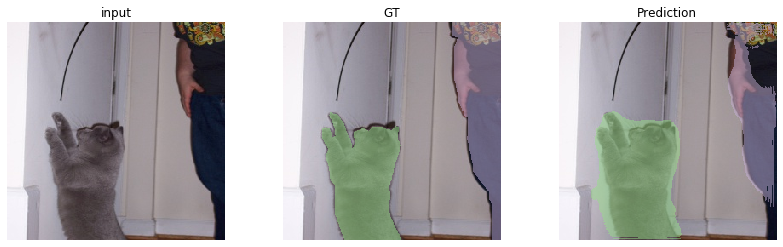

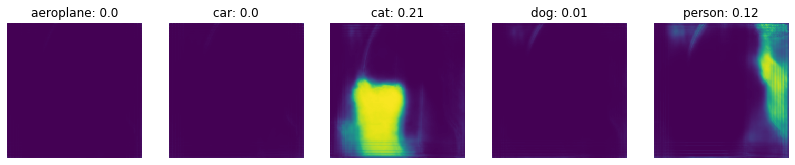

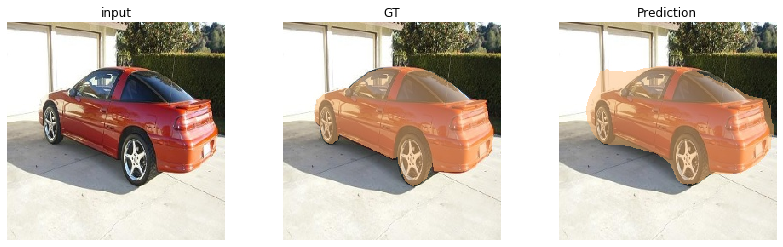

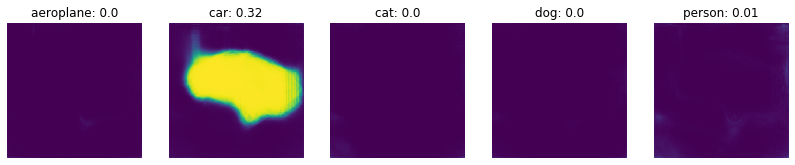

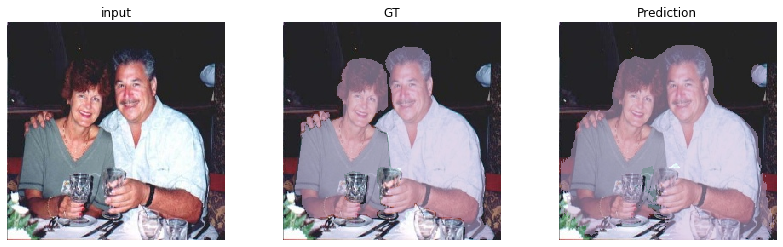

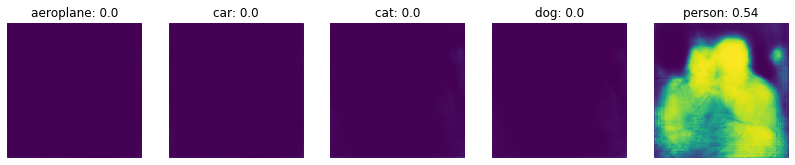

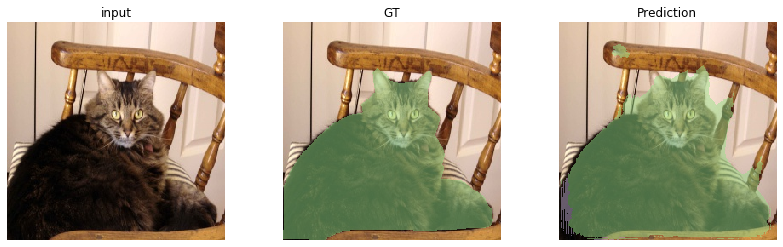

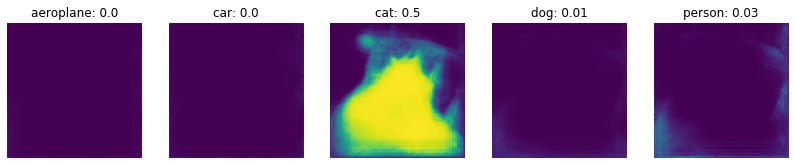

In [0]:
show_examples(model_pretrained)

In [0]:
end = time.time()
print('This total notebook took : {} minutes to run!'.format(round((end-start)/60)))

This total notebook took : 5 minutes to run!


## **3.4 Running on webcam images**

You can try your own images by capturing them from your webcam. Here, we simply resize regardless of aspect ratio - for images with unusual aspect ratio, results might be less good and cropping could be more appropriate.



In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image as Image_Ip
import requests
from io import BytesIO
from PIL import Image

def plot_segmentation(raw_in, seg_result):
  raw_in_256 = cv2.resize(raw_in, (256, 256), interpolation=cv2.INTER_LINEAR)
  seg_result_amax = np.argmax(seg_result, axis=2)
  plt.figure(figsize=(18, 5))
  plt.subplot(1, 2, 1)
  plt.title('input')
  plt.imshow(raw_in_256)
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.title('Prediction')
  plt.imshow(raw_in_256)
  plt.imshow(seg_result_amax, cmap=cmap_seg, vmin=0, vmax=N_CLASSES, alpha=0.8)
  plt.axis('off')

  plt.figure(figsize=(18, 5))
  for i, label in enumerate(labels[1:]):
        plt.subplot(1, 5, i+1)
        plt.title(label + ': ' + str(round(seg_result[:, :, i+1].mean(), 2)))
        plt.imshow(seg_result[:, :, i+1], vmin=0.0, vmax=1.0)
        plt.axis('off')

  plt.show()

<IPython.core.display.Javascript object>

saved to photo.jpg


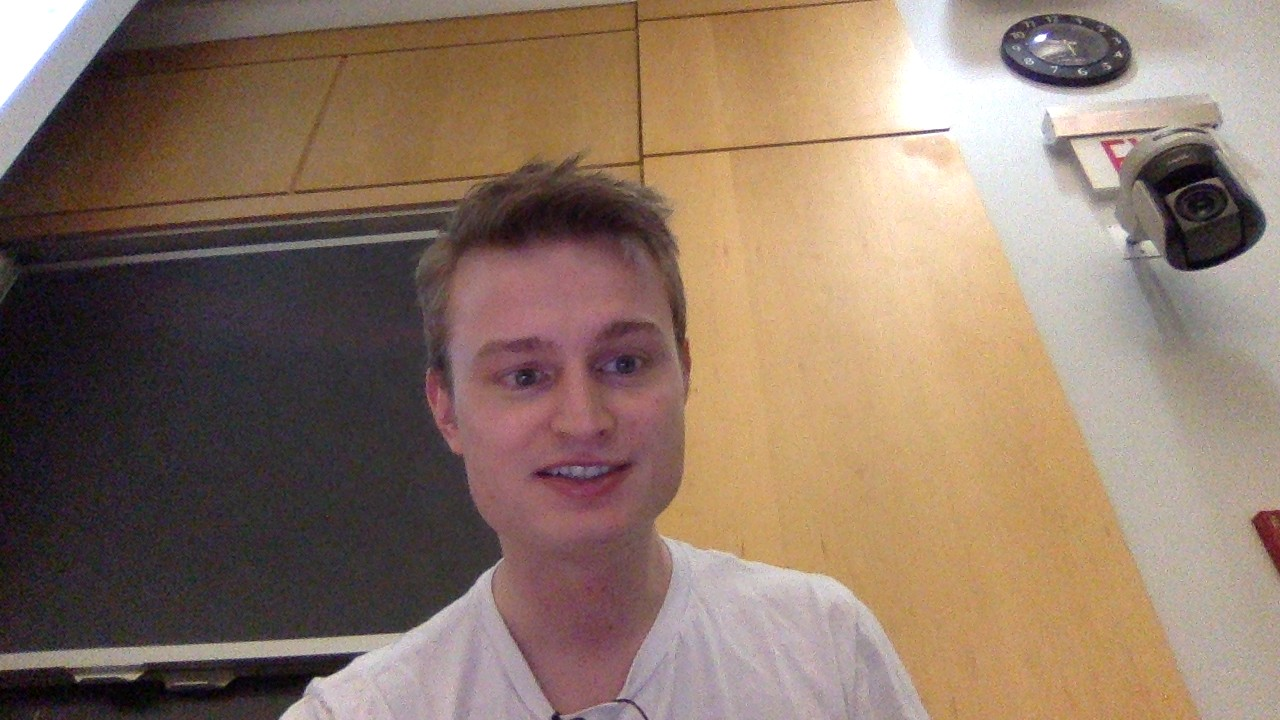

In [0]:
def take_photo(filename='photo.jpg', quality=0.9):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo()
  print('saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image_Ip(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

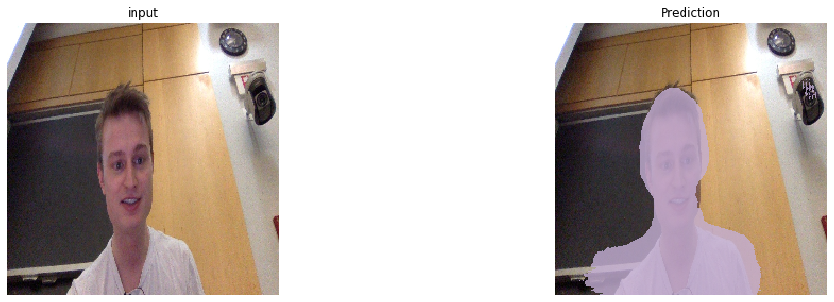

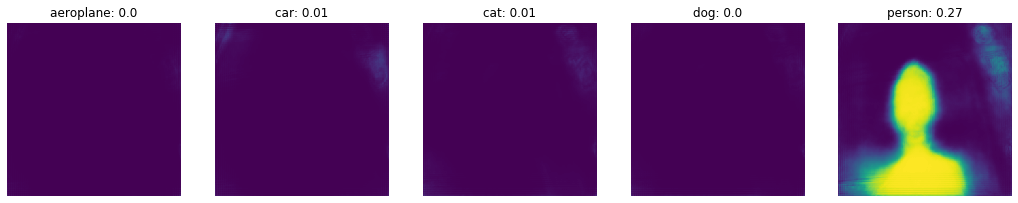

In [0]:
photo = np.flip(cv2.imread(filename), axis=2) / 255.
seg_result = run_predict(model_pretrained, np.expand_dims(photo, axis=0))[0]
plot_segmentation(photo, seg_result)

## **3.5 Running on external images**

Alternatively, you can try running the model on any publicly accessible image on the web. As in the previous section, we simply resize regardless of aspect ratio - for images with unusual aspect ratio, results might be less good and cropping could be more appropriate.

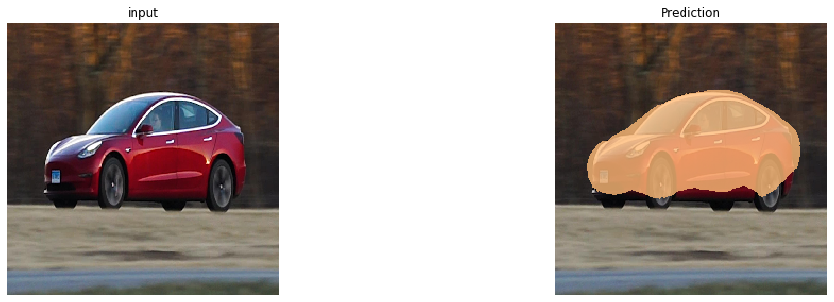

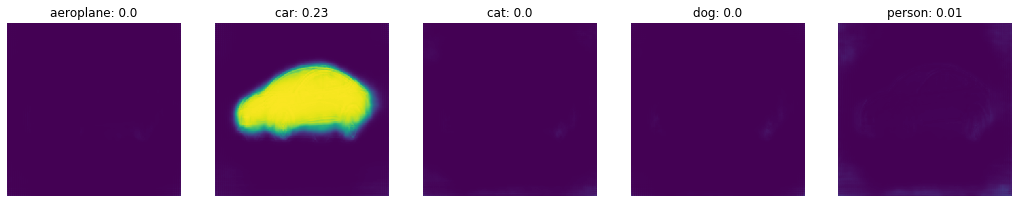

In [0]:
url = "https://f1.media.brightcove.com/8/1078702682/1078702682_6004950245001_6004956161001-vs.jpg?pubId=1078702682&videoId=6004956161001"
response = requests.get(url)
img_pil = Image.open(BytesIO(response.content))
img_web = np.array(img_pil.resize((256, 256))) / 255.

seg_result = run_predict(model_pretrained, np.expand_dims(img_web, axis=0))[0]
plot_segmentation(img_web, seg_result)

# **END OF NOTEBOOK**

------------------------

In [0]:
vars(model_scratch)

{'_activity_regularizer': None,
 '_autocast': False,
 '_callable_losses': [],
 '_collected_trainable_weights': [<tf.Variable 'conv8_1_3x3/kernel:0' shape=(3, 3, 1376, 128) dtype=float32, numpy=
  array([[[[-1.67456362e-02,  3.59253667e-04,  2.45005377e-02, ...,
            -2.07805894e-02,  4.44575073e-03,  1.28257414e-02],
           [-2.30153347e-03, -2.67508663e-02, -1.68016050e-02, ...,
            -4.60982788e-03,  3.50620918e-04, -5.33687510e-03],
           [-7.20371632e-03,  2.21935529e-02,  2.02513952e-02, ...,
            -1.72329694e-02, -1.11828102e-02,  1.87272672e-02],
           ...,
           [ 1.73345953e-02,  8.96355894e-04,  1.03383986e-02, ...,
            -3.18843732e-03,  9.99872852e-03, -8.44547059e-03],
           [-2.39904062e-03,  4.05802159e-03, -7.72694591e-03, ...,
            -7.55569199e-04,  1.46155180e-02,  9.79191251e-03],
           [ 1.31123913e-02,  2.94318562e-03, -1.83748864e-02, ...,
             1.20713515e-02, -1.56599935e-02, -1.81682152e-03]